Reference: https://colab.research.google.com/github/segments-ai/panoptic-segment-anything/blob/master/panoptic-segment-anything.ipynb

# Panoptic SAM


## Setup


In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Install the required libraries + code


In [2]:
!pip install -q transformers accelerate scipy safetensors segments-ai
!pip install -q git+https://github.com/facebookresearch/segment-anything.git

%cd /content/
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd /content/GroundingDINO
!pip install -q -e .
!pip install -q roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 7.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0

Import the libraries


In [3]:
import random
import requests

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from scipy import ndimage
from PIL import Image
from huggingface_hub import hf_hub_download
from segments import SegmentsClient
from segments.export import colorize
from segments.utils import bitmap2file
from getpass import getpass

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict
from GroundingDINO.groundingdino.util.inference import annotate, predict

# segment anything
from segment_anything import build_sam, SamPredictor

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

if device != "cpu":
    try:
        from GroundingDINO.groundingdino import _C
    except:
        warnings.warn(
            "Failed to load custom C++ ops. Running on CPU mode Only in groundingdino!"
        )

Using device: cuda


Download + load the Grounding DINO model


In [5]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device):
  cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

  args = SLConfig.fromfile(cache_config_file)
  model = build_model(args)
  args.device = device

  cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
  checkpoint = torch.load(cache_file, map_location="cpu")
  log = model.load_state_dict(clean_state_dict(checkpoint["model"]), strict=False)
  print("Model loaded from {} \n => {}".format(cache_file, log))
  _ = model.eval()
  model.to(device)
  return model


# Use this command for evaluate the Grounding DINO model
# Or you can download the model by yourself
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filename = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"

groundingdino_model = load_model_hf(
    ckpt_repo_id, ckpt_filename, ckpt_config_filename, device
)

GroundingDINO_SwinB.cfg.py:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

groundingdino_swinb_cogcoor.pth:   0%|          | 0.00/938M [00:00<?, ?B/s]

Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


Download SAM


In [6]:
! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2023-12-24 02:00:33--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.96, 3.163.189.51, 3.163.189.108, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   218MB/s    in 10s     

2023-12-24 02:00:43 (236 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



Load SAM


In [7]:
sam_checkpoint = "sam_vit_h_4b8939.pth"
sam = build_sam(checkpoint=sam_checkpoint)
sam.to(device=device)
sam_predictor = SamPredictor(sam)

## Panoptic SAM


### Helper methods


In [8]:
def download_image(url):
  return Image.open(requests.get(url, stream=True).raw)


def load_image_for_dino(image):
  transform = T.Compose(
      [
          T.RandomResize([800], max_size=1333),
          T.ToTensor(),
          T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
      ]
  )
  dino_image, _ = transform(image, None)
  return dino_image


def dino_detection(
    model,
    image,
    image_array,
    category_names,
    category_name_to_id,
    box_threshold,
    text_threshold,
    device,
    visualize=False,
):
    detection_prompt = " . ".join(category_names)
    # print("prompt: " + detection_prompt)
    dino_image = load_image_for_dino(image)
    dino_image = dino_image.to(device)
    with torch.no_grad():
        boxes, logits, phrases = predict(
            model=model,
            image=dino_image,
            caption=detection_prompt,
            box_threshold=box_threshold,
            text_threshold=text_threshold,
            device=device,
        )
    # print(phrases)
    # print(len(boxes))
    # print(logits)
    category_ids = [category_name_to_id[phrase] for phrase in phrases]

    if visualize:
        annotated_frame = annotate(
            image_source=image_array, boxes=boxes, logits=logits, phrases=phrases
        )
        annotated_frame = annotated_frame[..., ::-1]  # BGR to RGB
        visualization = Image.fromarray(annotated_frame)
        return boxes, category_ids, visualization
    else:
        return boxes, category_ids, phrases


def sam_masks_from_dino_boxes(predictor, image_array, boxes, device):
    # box: normalized box xywh -> unnormalized xyxy
    H, W, _ = image_array.shape
    boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])
    transformed_boxes = predictor.transform.apply_boxes_torch(
        boxes_xyxy, image_array.shape[:2]
    ).to(device)
    thing_masks, _, _ = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes,
        multimask_output=False,
    )
    return thing_masks

In [9]:
# filter small boxes
def filter_bboxes(w, h, bboxes, threshold_area=10000):
  result = []
  for bbox in bboxes:
    if int(bbox[2] * bbox[3] * w * h) >= threshold_area:
      result.append(bbox)
  if not result:
    # Return an empty tensor
    return torch.empty(0, 4)
  return torch.stack(result, dim = 0)

## Run Panoptic SAM on the whole dataset


In [ ]:
for sample in samples:
    image = download_image(sample.attributes.image.url)
    panoptic_inds, thing_category_ids = generate_panoptic_mask(
        image,
        thing_category_names,
        stuff_category_names,
        category_name_to_id,
        groundingdino_model,
        sam_predictor,
        clipseg_processor,
        clipseg_model,
        device,
    )
    upload_label(
        panoptic_inds,
        thing_category_ids,
        stuff_category_names,
        category_name_to_id,
        segments_client,
        sample,
    )

## Visualizations of the different pipeline steps


### Visualization Helper Methods

Let's first define some visualization methods to help us see what's going on in the pipeline.


In [10]:
from PIL import Image
import numpy as np

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def generate_sam_mask(image, masks):
    sam_masks = masks.squeeze(dim=1).cpu().numpy()
    combined_sam_masks = np.max(sam_masks, axis=0, keepdims=False).astype(np.uint8) * 255

    combined_sam_mask_image = Image.fromarray(combined_sam_masks, mode='L')
    return combined_sam_mask_image

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [11]:
from PIL import Image, ImageDraw

def generate_mask(image, boxes):
    mask = Image.new('L', image.size, 0)

    draw = ImageDraw.Draw(mask)

    for box in boxes:
        draw.rectangle([box[0], box[1], box[0] + box[2], box[1] + box[3]], fill="white")

    return mask

def draw_red_box(image, boxes):
    img = image.copy()

    draw = ImageDraw.Draw(img)

    for box in boxes:
        draw.rectangle([box[0], box[1], box[0] + box[2], box[1] + box[3]], outline="red", width=2)

    return img

### Pipeline: Generate mask and SAM mask from one frame (Demo Part)

Input image


In [13]:
%cd /content/drive/Shareddrives/視訊壓縮小組/dashcam

/content/drive/Shareddrives/視訊壓縮小組/dashcam


Run the following block to get sample images from video

In [ ]:
# import cv2
# import numpy as np
# import os

# def extract_frames(input_video, output_folder, num_frames=10):
#     os.makedirs(output_folder, exist_ok=True)
#     cap = cv2.VideoCapture(input_video)
#     total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
#     interval = max(total_frames // num_frames, 1)
#     selected_frame_indices = list(range(0, total_frames, interval))

#     for frame_index in selected_frame_indices:
#         cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
#         ret, frame = cap.read()
#         if ret:
#             output_file = os.path.join(output_folder, f"frame_{frame_index}.jpg")
#             cv2.imwrite(output_file, frame)

#     cap.release()

# if __name__ == "__main__":
#     input_video_path = "行車記錄器_V80GH_前鏡頭日間實測影片.mp4"  # 更換為你的影片路徑
#     output_folder_path = "output_frames"  # 更換為你希望儲存的文件夾路徑

#     extract_frames(input_video_path, output_folder_path)

In [14]:
# image_url = "https://segmentsai-prod.s3.eu-west-2.amazonaws.com/assets/admin-tobias/996f3571-66d8-4dfd-8c1a-402d7c0c820b.png"
image_name = "frame_1008.jpg"
image_path = "output_frames/" + image_name
thing_category_names = ["car", "person", "bus", "motorcycle", "bicycle"]
# stuff_category_names = ["building", "road", "sky", "trees", "sidewalk"]
category_names = thing_category_names # + stuff_category_names
category_name_to_id = {
    category_name: i for i, category_name in enumerate(category_names)
}
category_name_to_id

{'car': 0, 'person': 1, 'bus': 2, 'motorcycle': 3, 'bicycle': 4}

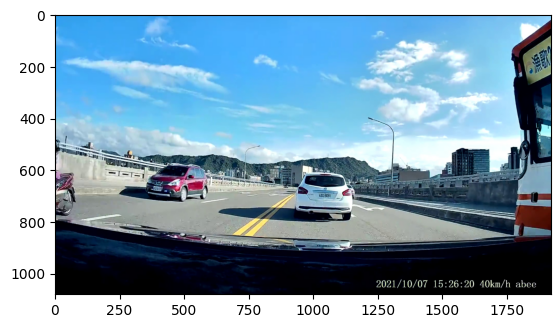

In [15]:
image = Image.open(image_path)
image = image.convert("RGB")
image_array = np.asarray(image)
plt.imshow(image_array)

Boxes for "thing" categories from Grounding DINO


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


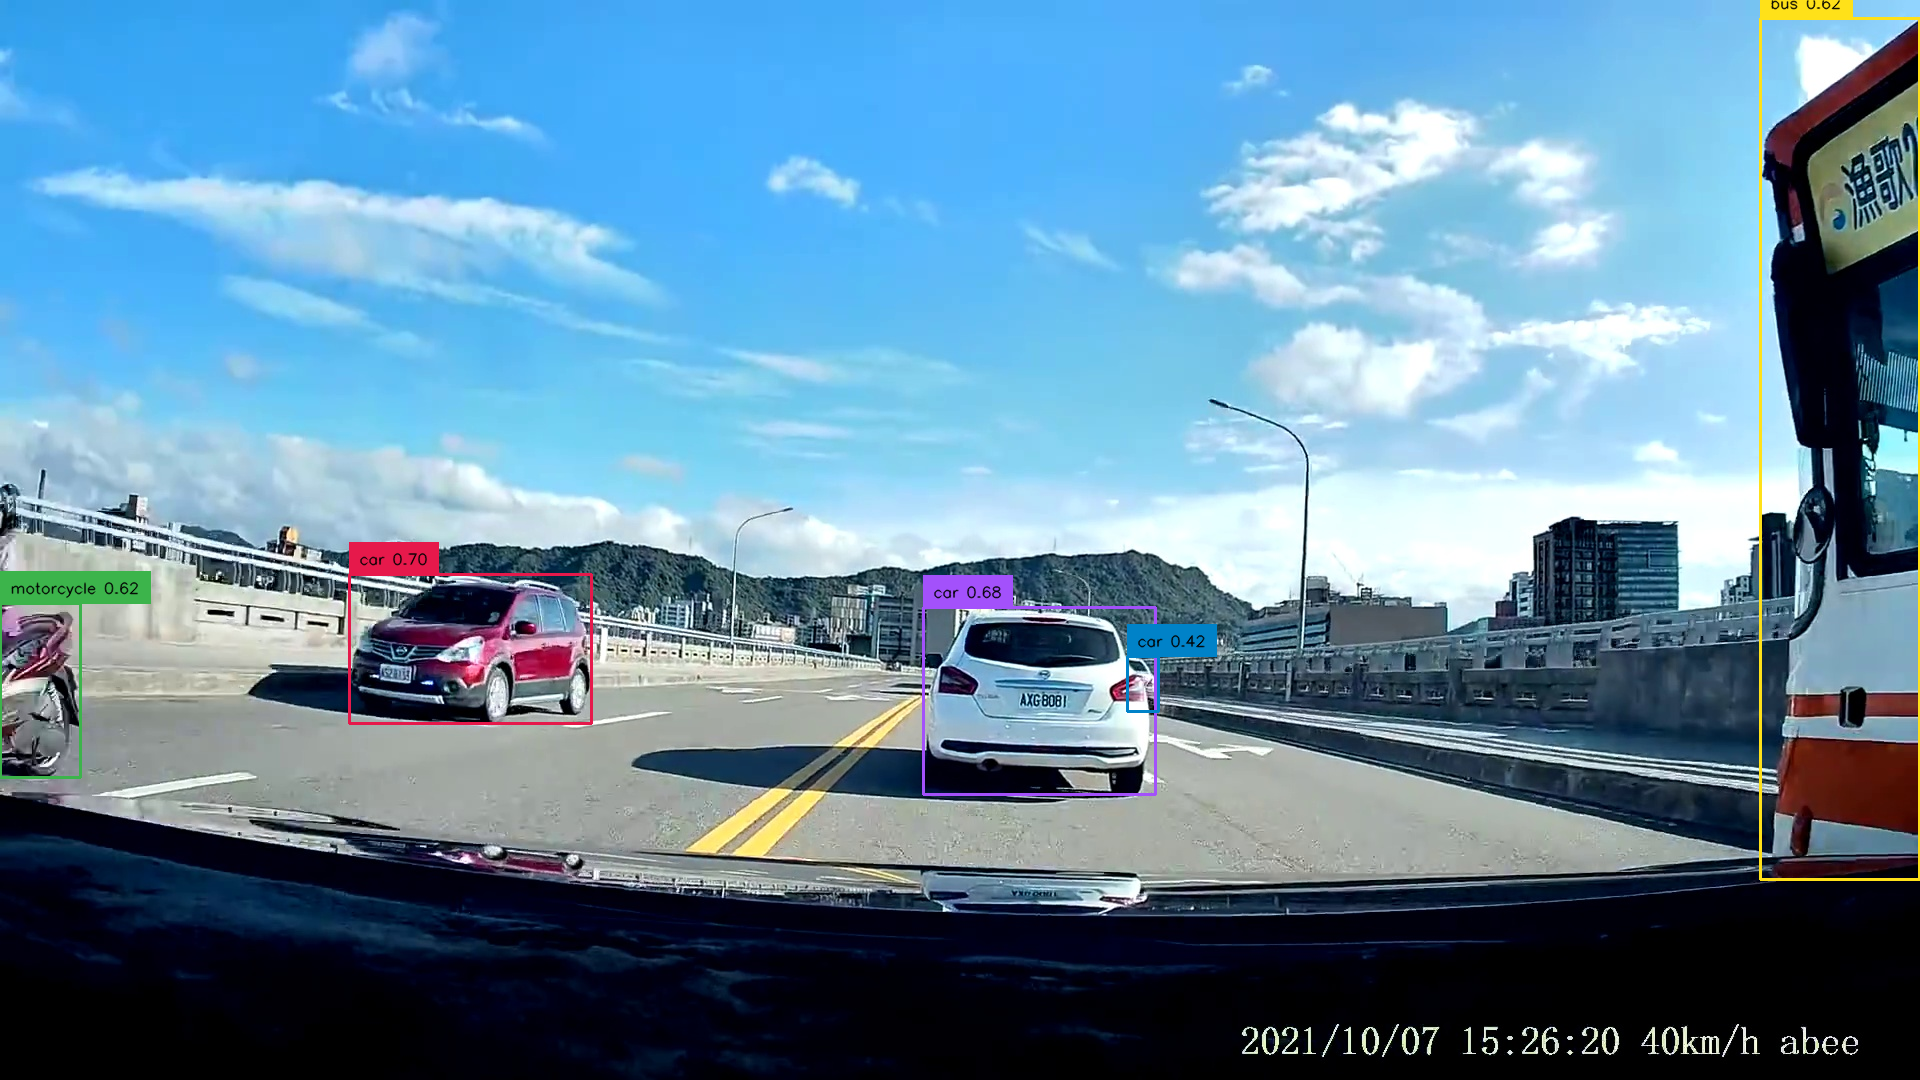

In [16]:
dino_box_threshold = 0.4
dino_text_threshold = 0.3

thing_boxes, thing_category_ids, visualization = dino_detection(
    groundingdino_model,
    image,
    image_array,
    thing_category_names,
    category_name_to_id,
    dino_box_threshold,
    dino_text_threshold,
    device,
    visualize=True,
)

# print(type(thing_boxes))
# print(type(thing_boxes[0]))
# for i in range(len(thing_boxes)):
#   print(thing_category_ids[i], thing_boxes[i])
visualization

[[923, 607, 231, 187], [349, 574, 241, 148], [0, 603, 79, 174], [1760, 18, 158, 860]]


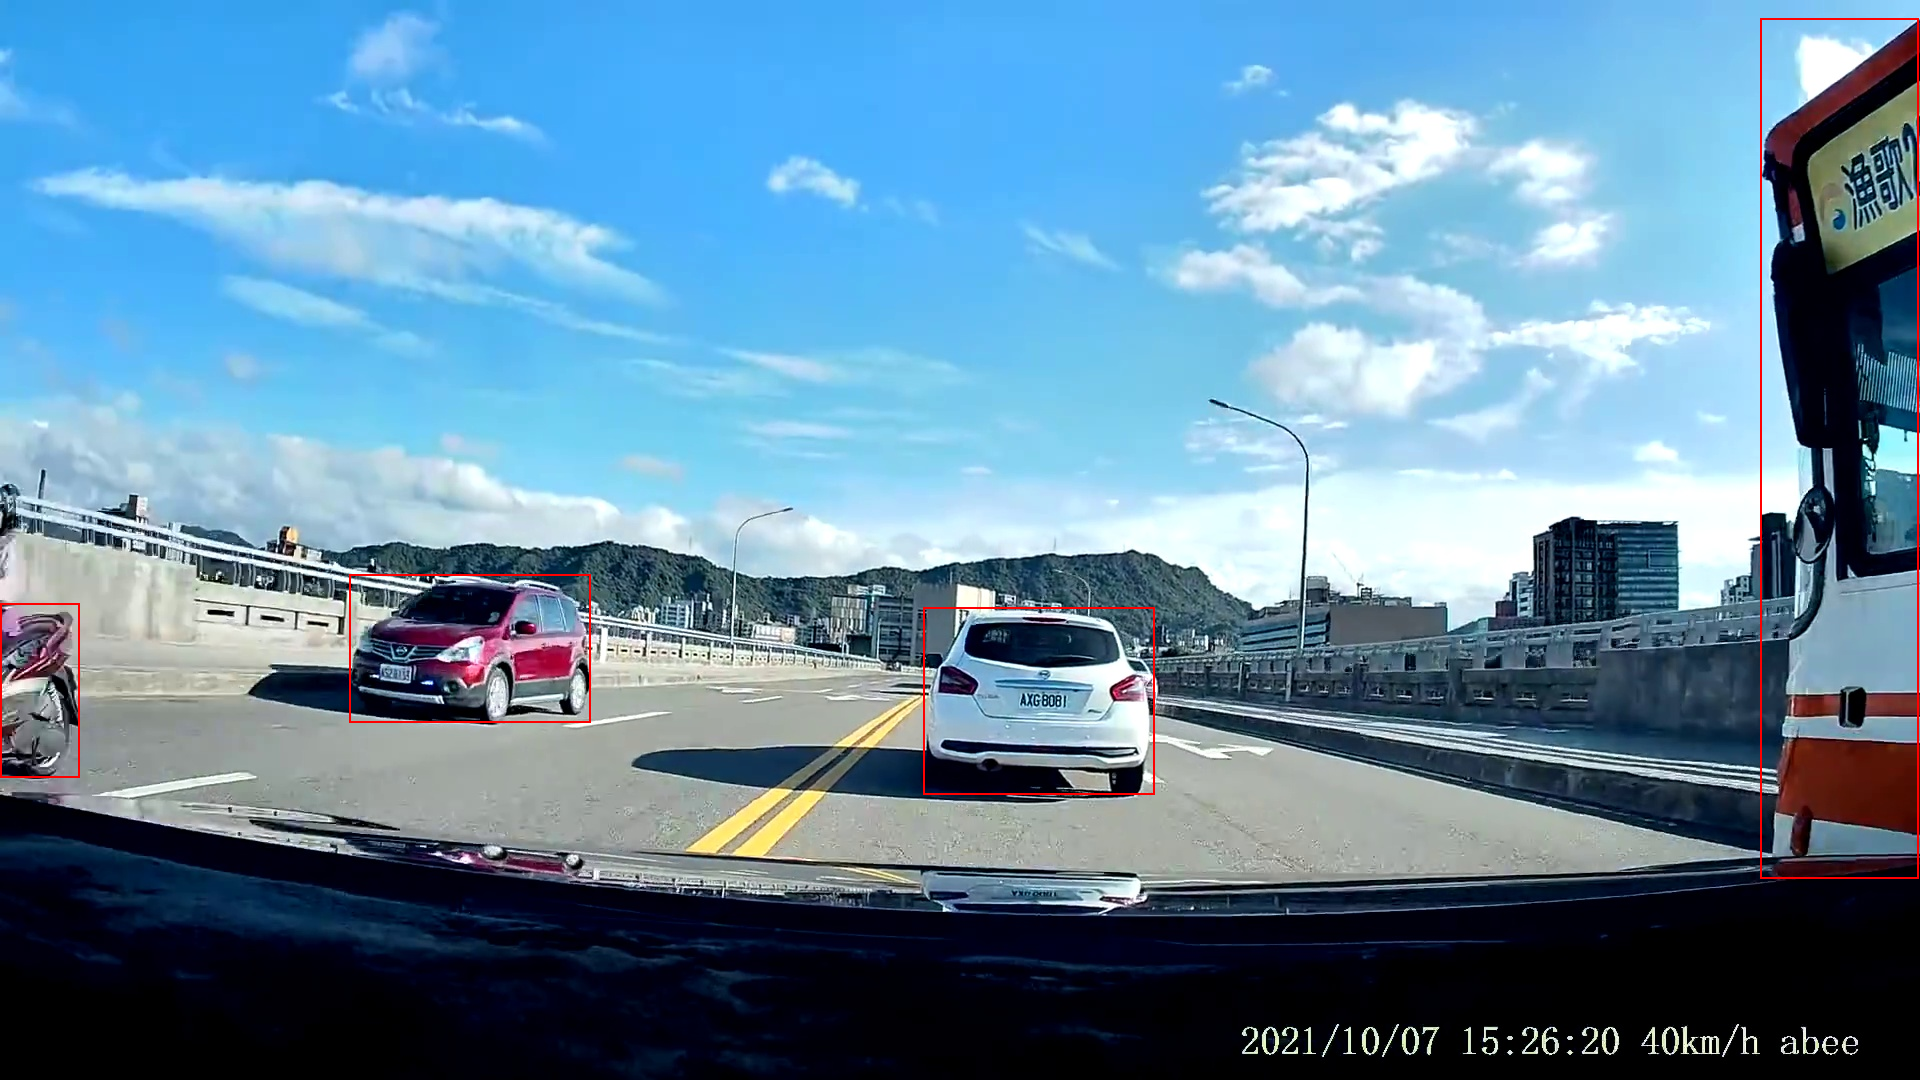

In [17]:
width, height = image.size
boxes = np.array(filter_bboxes(width, height, thing_boxes))
boxes = [[int((box[0] - box[2]/2) * width), int((box[1] - box[3] / 2) * height), int(box[2] * width), int(box[3] * height)] for box in boxes]
print(boxes)
img = draw_red_box(image, boxes)
img

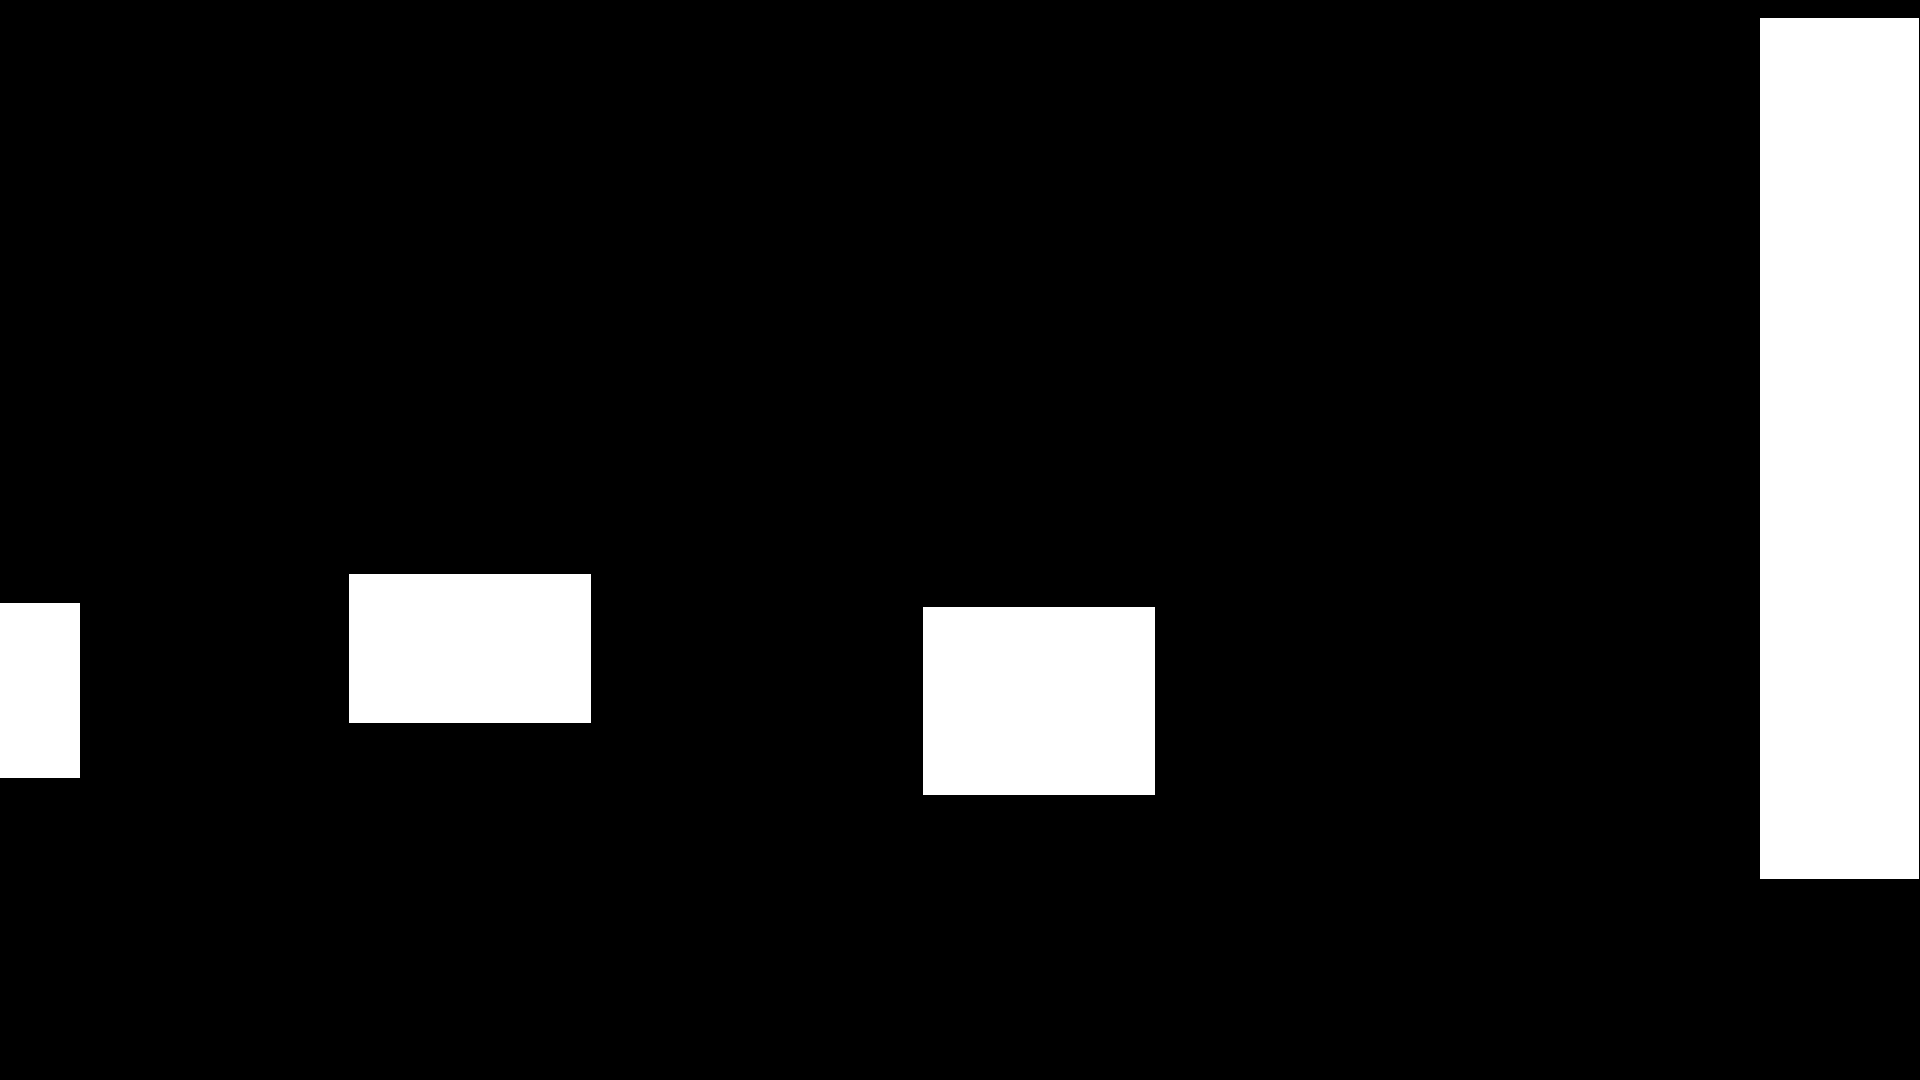

In [18]:
mask = generate_mask(image, boxes)
# save_path = "mask_frames/" + image_name
# mask.save(save_path)
mask

Segmentation masks for the thing boxes from SAM


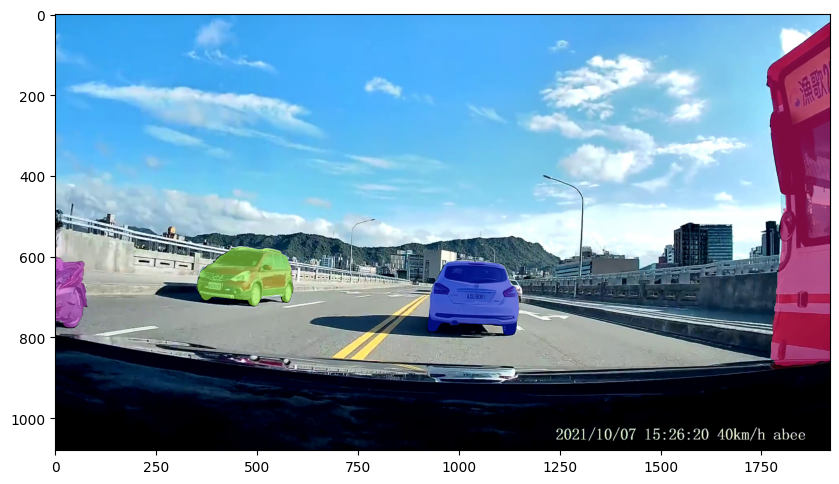

In [19]:
# compute SAM image embedding
sam_predictor.set_image(image_array)
thing_boxes = filter_bboxes(width, height, thing_boxes)
thing_masks = sam_masks_from_dino_boxes(sam_predictor, image_array, thing_boxes, device)
plt.figure(figsize=(10, 10))
plt.imshow(image)
for thing_mask in thing_masks:
  show_mask(thing_mask.cpu().numpy(), plt.gca(), random_color=True)

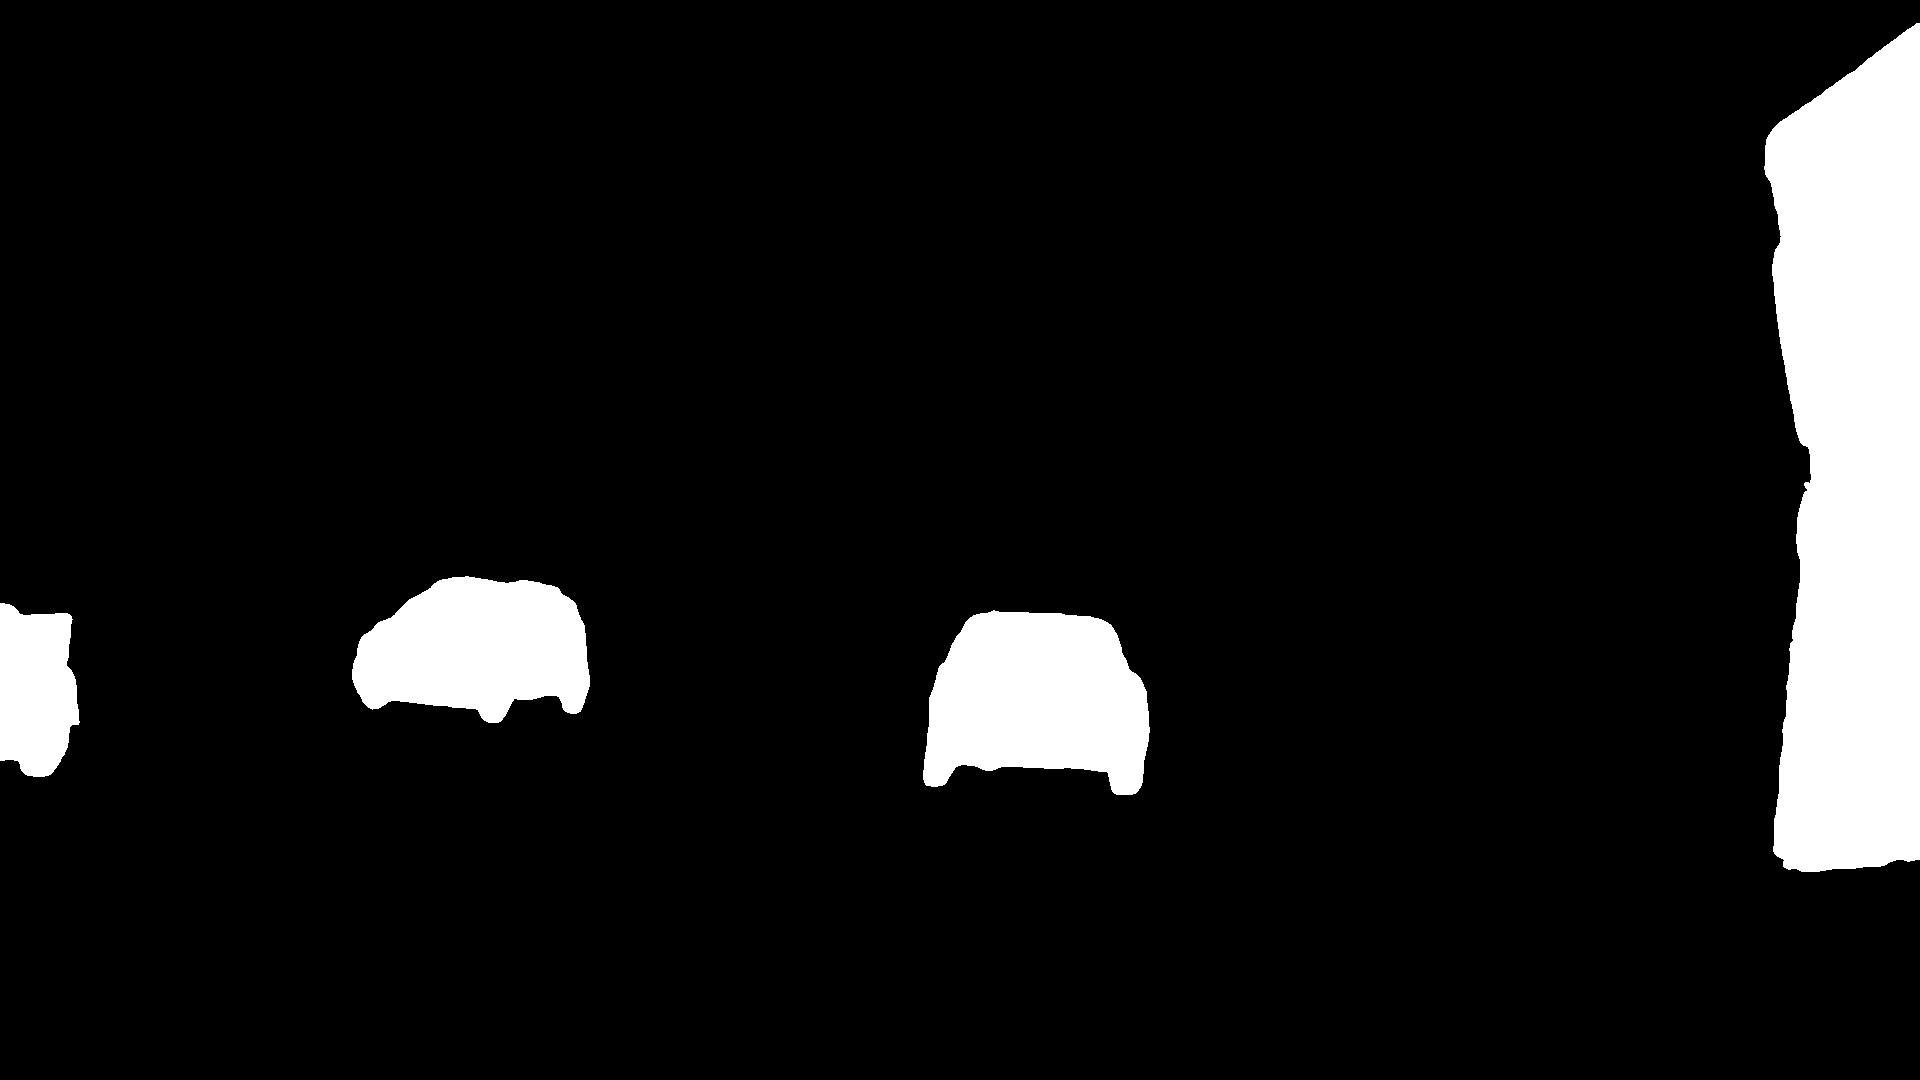

In [19]:
sam_mask = generate_sam_mask(image, thing_masks)
# sam_save_path = "sam_mask_frames/" + image_name
# sam_mask.save(sam_save_path)
sam_mask

## Video generation

### Run the following code to get single video mask

In [12]:
%cd /content/drive/Shareddrives/視訊壓縮小組/monitor/AvenueDataset/training_videos

/content/drive/Shareddrives/視訊壓縮小組/monitor/AvenueDataset/training_videos


In [ ]:
import cv2
import numpy as np
import os, sys
from PIL import Image
from collections import defaultdict


def generate_video_masks(input_video_folder, input_video_name, mask_folder_path, sample_interval, filter=False, threshold_area=10000):
  cap = cv2.VideoCapture(input_video_folder + input_video_name)

  if not cap.isOpened():
    print("無法開啟影片")
    return

  fps = int(cap.get(cv2.CAP_PROP_FPS))
  frame_size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
  frame_interval = int(fps * sample_interval)

  # VideoWriter to store processed video
  os.makedirs(mask_folder_path, exist_ok=True)
  mask_video_path = mask_folder_path + 'mask_' + str(frame_interval) + "_" + input_video_name
  # mask_video_path = mask_folder_path + 'mask_' + str(frame_interval) + "_" + '01.mp4'
  print(mask_video_path)

  if input_video_name[-3:].lower() == 'avi':
    fourcc = cv2.VideoWriter_fourcc(*(int(cap.get(cv2.CAP_PROP_FOURCC)).to_bytes(4, byteorder=sys.byteorder).decode()))
    print(fourcc)
  else:
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    print(fourcc)
  mask_out = cv2.VideoWriter(mask_video_path, fourcc, fps, frame_size)
  # cap.release()
  # mask_out.release()
  # return
  frame_num = 0
  frame_processed = None

  # dino setting
  thing_category_names = ["car", "person", "bus", "motorcycle", "bicycle"]
  category_names = thing_category_names # + stuff_category_names
  category_name_to_id = defaultdict(lambda: "others", {category_name: i for i, category_name in enumerate(category_names)})
  dino_box_threshold = 0.4
  dino_text_threshold = 0.3
  width, height = frame_size

  while True:
    ret, frame = cap.read()

    if not ret:
      break
    if frame_num % frame_interval != 0:
      mask_out.write(frame_processed)
      frame_num += 1
      continue

    image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    image_array = np.asarray(image)

    thing_boxes, thing_category_ids, visualization = dino_detection(
        groundingdino_model,
        image,
        image_array,
        thing_category_names,
        category_name_to_id,
        dino_box_threshold,
        dino_text_threshold,
        device,
        visualize=True,
    )
    if filter:
      boxes = np.array(filter_bboxes(width, height, thing_boxes, threshold_area)) # filtered
    else:
      boxes = np.array(thing_boxes) # non-filter
    boxes = [[int((box[0] - box[2]/2) * width), int((box[1] - box[3] / 2) * height), int(box[2] * width), int(box[3] * height)] for box in boxes]

    mask = generate_mask(image, boxes)

    # 將處理後的帧寫入 VideoWriter
    frame_processed = cv2.cvtColor(np.array(mask), cv2.COLOR_RGB2BGR)
    mask_out.write(frame_processed)
    frame_num += 1

  print(frame_num)

  # 釋放資源
  cap.release()
  mask_out.release()
  # cv2.destroyAllWindows()

In [ ]:
input_video_folder = "/content/drive/Shareddrives/視訊壓縮小組/monitor/AvenueDataset/training_videos/"  # video folder path
input_video_name = "01.avi" # video name
mask_folder_path = "/content/drive/Shareddrives/視訊壓縮小組/monitor/mask_video/AvenueDataset/training_videos/"  # output mask folder path
# input_video_folder = "/content/drive/Shareddrives/視訊壓縮小組/dashcam/"  # video folder path
# input_video_name = "11.mp4"
# mask_folder_path = "/content/drive/Shareddrives/視訊壓縮小組/dashcam/mask_video/"  # output mask folder path
sample_interval = 0.5 # seconds
threshold_area = 10000
filter = True
if filter:
  mask_folder_path += "filterd/"
else:
  mask_folder_path += "non-filter/"

generate_video_masks(input_video_folder, input_video_name, mask_folder_path, sample_interval, filter, threshold_area)

/content/drive/Shareddrives/視訊壓縮小組/monitor/mask_video/AvenueDataset/training_videos/filterd/mask_12_01.avi
877677894


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


RuntimeError: ignored

In [ ]:
import cv2
import numpy as np
import os
from PIL import Image
from collections import defaultdict


def generate_sam_masks(input_video_folder, input_video_name, sam_folder_path, sample_interval, filter=True, threshold_area=10000):
  cap = cv2.VideoCapture(input_video_folder + input_video_name)

  if not cap.isOpened():
    print("無法開啟影片")
    return

  fps = int(cap.get(cv2.CAP_PROP_FPS))
  frame_size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
  frame_interval = int(fps * sample_interval)

  # VideoWriter to store processed video
  os.makedirs(sam_folder_path, exist_ok=True)
  sam_video_path = sam_folder_path + 'sam_' + str(frame_interval) + "_" + input_video_name
  print(sam_video_path)
  if input_video_name[-3:].lower() == 'avi':
    fourcc = cv2.VideoWriter_fourcc(*(int(cap.get(cv2.CAP_PROP_FOURCC)).to_bytes(4, byteorder=sys.byteorder).decode()))
    print(fourcc)
  else:
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    print(fourcc)
  sam_out = cv2.VideoWriter(sam_video_path, fourcc, fps, frame_size)
  frame_num = 0
  frame_processed = None

  # dino setting
  thing_category_names = ["car", "person", "bus", "motorcycle", "bicycle"]
  category_names = thing_category_names # + stuff_category_names
  category_name_to_id = defaultdict(lambda: "others", {category_name: i for i, category_name in enumerate(category_names)})
  dino_box_threshold = 0.4
  dino_text_threshold = 0.3
  width, height = frame_size

  while True:
    ret, frame = cap.read()

    if not ret:
      break

    if frame_num % frame_interval != 0:
      sam_out.write(frame_processed)
      frame_num += 1
      continue

    image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    image_array = np.asarray(image)

    thing_boxes, thing_category_ids, visualization = dino_detection(
        groundingdino_model,
        image,
        image_array,
        thing_category_names,
        category_name_to_id,
        dino_box_threshold,
        dino_text_threshold,
        device,
        visualize=True,
    )

    sam_predictor.set_image(image_array)
    # print(type(image_array))
    if filter:
      thing_boxes = filter_bboxes(width, height, thing_boxes, threshold_area)
    if len(thing_boxes) > 0:
      thing_masks = sam_masks_from_dino_boxes(sam_predictor, image_array, thing_boxes, device) # non-filter
      sam_mask = generate_sam_mask(image, thing_masks)
    else:
      sam_mask = Image.new('L', image.size, 0)

    # 將處理後的帧寫入 VideoWriter
    frame_processed = cv2.cvtColor(np.array(sam_mask), cv2.COLOR_RGB2BGR)
    sam_out.write(frame_processed)
    frame_num += 1


  # 釋放資源
  cap.release()
  sam_out.release()
  # cv2.destroyAllWindows()

In [ ]:
# input_video_folder = "/content/drive/Shareddrives/視訊壓縮小組/monitor/AvenueDataset/training_videos/"  # video folder path
# input_video_name = "16.avi" # video name
# sam_folder_path = "/content/drive/Shareddrives/視訊壓縮小組/monitor/sam_mask_video/AvenueDataset/training_videos/"  # output mask folder path
input_video_folder = "/content/drive/Shareddrives/視訊壓縮小組/dashcam/"  # video folder path
input_video_name = "11.mp4"
sam_folder_path = "/content/drive/Shareddrives/視訊壓縮小組/dashcam/sam_mask_video/"  # output mask folder path
sample_interval = 0.5 # seconds
threshold_area = 10000
filter = False
if filter:
  sam_folder_path += "filterd/"
else:
  sam_folder_path += "non-filter/"

generate_sam_masks(input_video_folder, input_video_name, sam_folder_path, sample_interval, filter, threshold_area)

/content/drive/Shareddrives/視訊壓縮小組/dashcam/sam_mask_video/non-filter/sam_15_11.mp4
1446269005
